<a href="https://colab.research.google.com/github/Goshikhar23/DL-back-to-the-basics/blob/master/HyperParameterTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [ ]:
np.random.seed(0)

# Generate data

In [ ]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


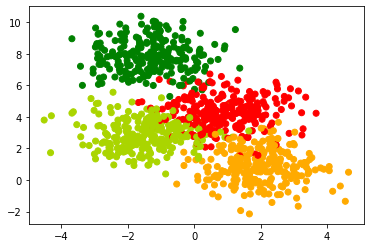

In [ ]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [ ]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

# MultiClass Classification

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [ ]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


# Activation Functions

In [ ]:
act_functions = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
def sigmoid(x):
  s = 1/(1 + np.exp(-x))
  ds = s * (1-s)
  return s, ds

def tanh(x):
  t = (np.exp(x) - np.exp(-x))/((np.exp(x) + np.exp(-x)))
  dt = 1- (t)**2
  return t, dt

def relu(x):
  r = np.maximum(0, x)
  dr = 1 * (x > 0)
  return r, dr

def leaky_relu(x, leaky_slope=0.1):
  l = np.maximum(leaky_slope*x, x)
  dl=np.zeros_like(x)
  dl[x<=0]=leaky_slope
  dl[x>0]=1
  return l, dl

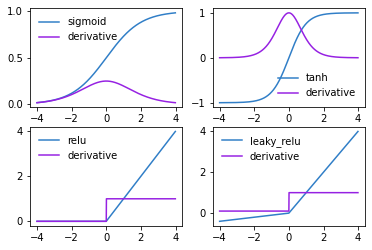

In [ ]:
X = np.arange(-4, 4, 0.01)

for i in range(len(act_functions)):
  plt.subplot(2, 2, i+1)
  if act_functions[i]=='sigmoid':
    y, dy = sigmoid(X)
  elif act_functions[i]=='tanh':
    y, dy = tanh(X)
  elif act_functions[i]=='relu':
    y, dy = relu(X)
  elif act_functions[i]=='leaky_relu':
    y, dy = leaky_relu(X)
  
  plt.plot(X, y, color="#307EC7", label=act_functions[i])
  plt.plot(X, dy, color="#9621E2", label="derivative")
  plt.legend(loc="best", frameon=False)
plt.show()

# Initialization methods

In [ ]:
init_methods = ["zeros", "random", "Xavier", "he"]

# GD Variants

In [ ]:
gd_variants = ["GD", "MiniBatch", "Momentum", "NAG","AdaGrad", "RMSProp", "Adam"]

# FFN Class

In [ ]:
class FFN():

  def __init__(self, n_inputs= 2, n_outputs=4, hidden_layers=[2], gd_variant='GD', init_method= 'random', activation_function= 'sigmoid', leaky_slope = 0.1):
    self.nx = n_inputs
    self.ny = n_outputs
    self.num_layers = len(hidden_layers) + 1  # 1 for output layer
    self.layer_sizes = [self.nx] + hidden_layers + [self.ny]
    self.l =None
    self.params = {}
    self.params_a_h = {}
    self.params_hist = []

    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    
    np.random.seed(0)

    if init_method == 'random':
      for i in range(1, self.num_layers + 1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])
    
    elif init_method == 'he':
      for i in range(1, self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])

    elif init_method == 'Xavier':
      for i in range(1, self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])

    elif init_method == 'zeros':
      for i in range(1, self.num_layers+1):
        self.params["W"+str(i)] = np.zeros((self.layer_sizes[i-1], self.layer_sizes[i]))
        self.params["B"+str(i)] = np.zeros((1, self.layer_sizes[i]))

    self.gradients = {}
    self.update_params = {}
    self.prev_update_params = {}
    for i in range(1, self.num_layers + 1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0

  
  def forward_activation(self, X):
    if self.activation_function == 'sigmoid':
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == 'tanh':
      return np.tanh(X)
    elif self.activation_function == 'relu':
      return np.maximum(0, X)
    elif self.activation_function == 'leaky_relu':
      return np.maximum(self.leaky_slope * X, X)
  
  def grad_activation(self, X):
    if self.activation_function == 'sigmoid':
      return X * (1- X)
    elif self.activation_function == 'tanh':
      return (1 - np.square(X))
    elif self.activation_function == 'relu':
      return 1.0 * (X > 0)
    elif self.activation_function == 'leaky_relu':
      d = np.zeros_like(X)
      d[X>0] = 1
      d[X<=0] = self.leaky_slope
      return d

  def softmax(self, X):
    exps = np.exp(X)
    return exps/np.sum(exps, axis=1).reshape(-1, 1)

  def forward_pass(self, X, params=None):
    if params is None:
      params = self.params
    
    self.params_a_h["H"+str(0)] = X
    
    for i in range(1, self.num_layers+1):  # Upto output layer
      self.params_a_h["A"+str(i)] = np.matmul(self.params_a_h["H"+str(i-1)], self.params["W"+str(i)]) + self.params["B"+str(i)]
      self.params_a_h["H"+str(i)] = self.forward_activation(self.params_a_h["A"+str(i)])
    self.params_a_h["H"+str(self.num_layers)] = self.softmax(self.params_a_h["A"+str(self.num_layers)])
    return self.params_a_h["H"+str(self.num_layers)]

  def grad(self, X, Y, params=None):
    if params is None:
      params = self.params
    
    self.gradients["dA"+str(self.num_layers)] = self.forward_pass(X, params) - Y
    m = X.shape[0]
    for k in range(self.num_layers, 0, -1):
      self.gradients["dW"+str(k)] = np.matmul(self.params_a_h["H"+str(k-1)].T, self.gradients["dA"+str(k)])
      self.gradients["dB"+str(k)] = np.sum(self.gradients["dA"+str(k)], axis=0).reshape(1, -1)
      self.gradients["dH"+str(k-1)] = np.matmul(self.gradients["dA"+str(k)], self.params["W"+str(k)].T)
      self.gradients["dA"+str(k-1)] = np.multiply(self.gradients["dH"+str(k-1)], self.grad_activation(self.params_a_h["H"+str(k-1)]))
  
  def fit(self, X, Y, epochs=1, algo='GD', display_loss=False, eta=1, mini_batch_size=100, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9):

    if display_loss:
      loss = {}
      Y_pred = self.predict(X)
      loss[0] = log_loss(np.argmax(Y, axis=1), Y_pred)

    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
          
      if display_loss:
        Y_pred = self.predict(X)
        loss[num_epoch+1] = log_loss(np.argmax(Y, axis=1), Y_pred)
        a= np.concatenate((self.params["W"+str(1)].ravel(), self.params["B"+str(1)].ravel()))
        self.l = 0
        for i in range(2, self.num_layers+1):
          a=np.concatenate((a, self.params["W"+str(i)].ravel(), self.params["B"+str(i)].ravel()))
          self.l+= len(a)
        self.params_hist.append(a)
    
    if display_loss:
      plt.plot(list(loss.values()), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()

  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()
    

    


# Post Process

In [ ]:
def post_process(scatter_plot=False, gradient_plot=True, plot_scale=0.1):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))    
    
    if scatter_plot:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()
      
    if gradient_plot:
      h = np.asarray(model.params_hist)
      h_diff = (h[0:-1, :] - h[1:, :])
      for i in range(model.l):
        plt.subplot(model.l/2, 2, i+1)
        plt.plot(h_diff[:, i], '-')
        plt.ylim((-plot_scale, plot_scale))
        plt.yticks([])
        plt.xticks([])
      plt.show()

# Different Hyperparameters Training

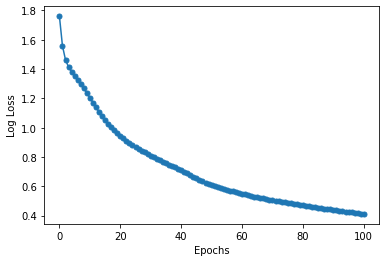

Total no. of parameters:  32
Training accuracy 0.888
Validation accuracy 0.88


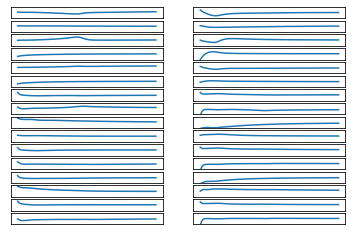

In [ ]:
model = FFN(n_inputs= 2, n_outputs=4, hidden_layers=[4], gd_variant='Adam', init_method= 'he', activation_function= 'sigmoid', leaky_slope = 0.1)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="GD", display_loss=True)
print("Total no. of parameters: ", model.l)
post_process()

GD zeros sigmoid


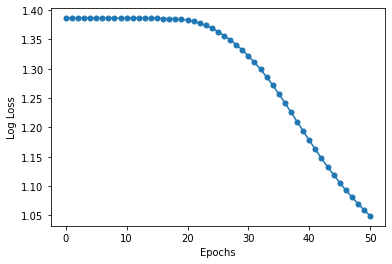

Training accuracy 0.528
Validation accuracy 0.54


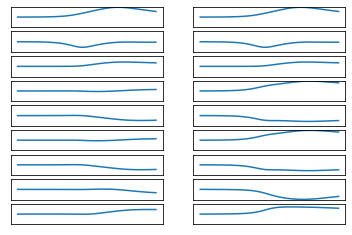


--

GD zeros tanh


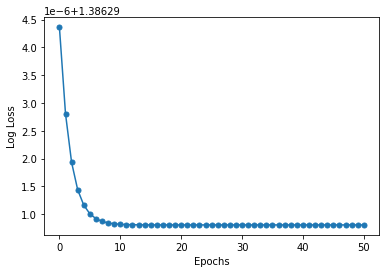

Training accuracy 0.2507
Validation accuracy 0.248


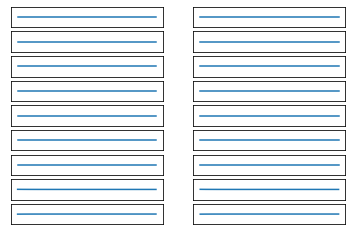


--

GD zeros relu


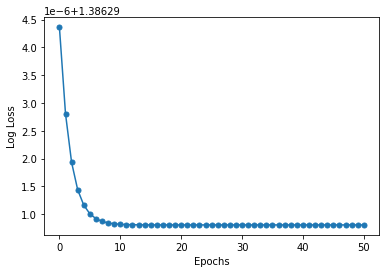

Training accuracy 0.2507
Validation accuracy 0.248


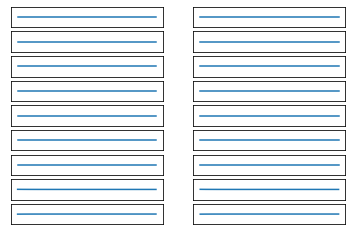


--

GD zeros leaky_relu


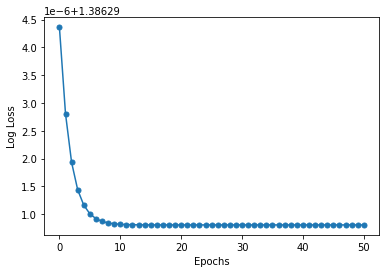

Training accuracy 0.2507
Validation accuracy 0.248


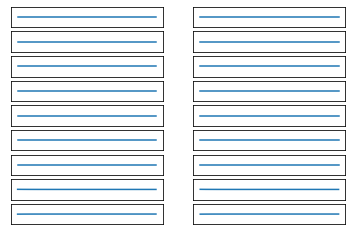


--

GD random sigmoid


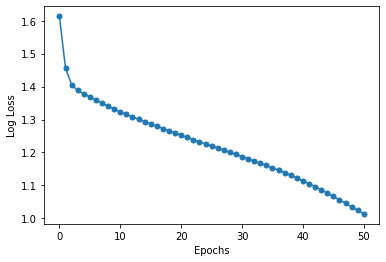

Training accuracy 0.5827
Validation accuracy 0.568


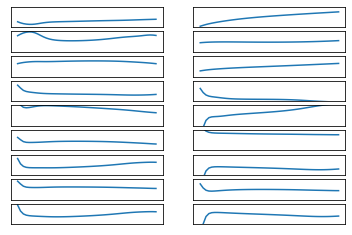


--

GD random tanh


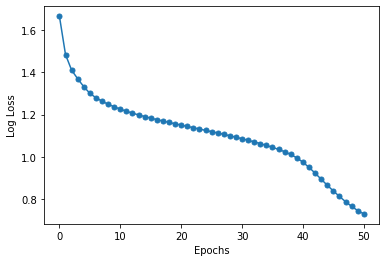

Training accuracy 0.68
Validation accuracy 0.676


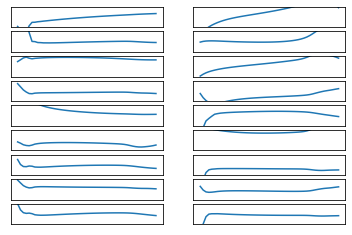


--

GD random relu


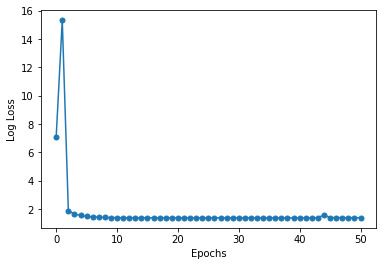

Training accuracy 0.2507
Validation accuracy 0.248


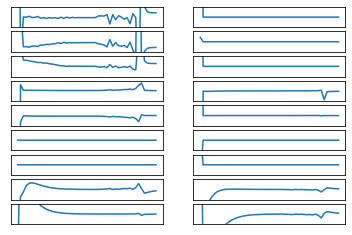


--

GD random leaky_relu


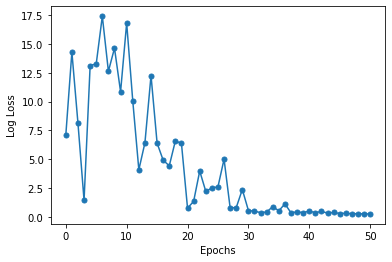

Training accuracy 0.904
Validation accuracy 0.92


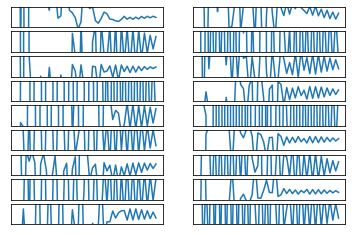


--

GD Xavier sigmoid


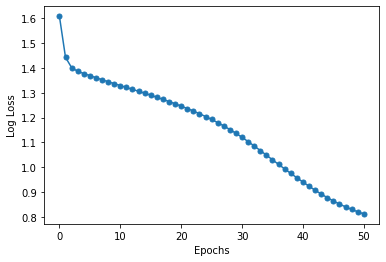

Training accuracy 0.8747
Validation accuracy 0.88


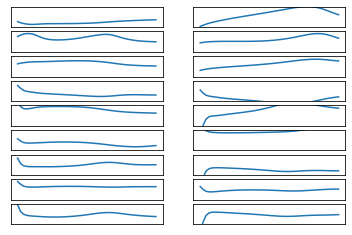


--

GD Xavier tanh


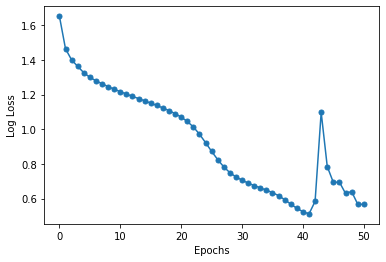

Training accuracy 0.8507
Validation accuracy 0.86


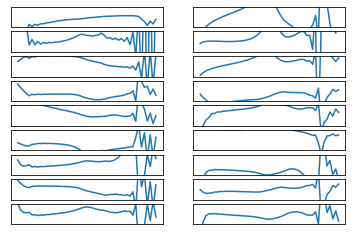


--

GD Xavier relu


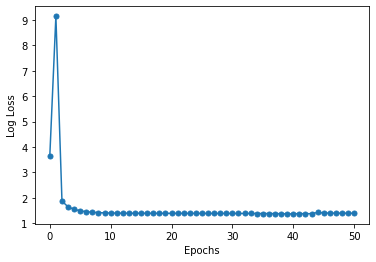

Training accuracy 0.2507
Validation accuracy 0.248


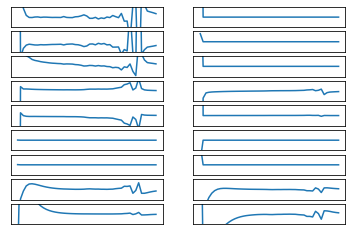


--

GD Xavier leaky_relu


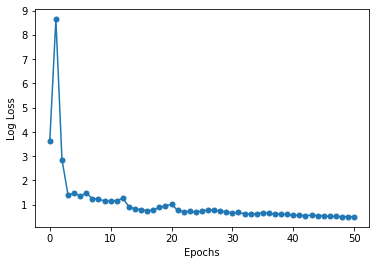

Training accuracy 0.8227
Validation accuracy 0.832


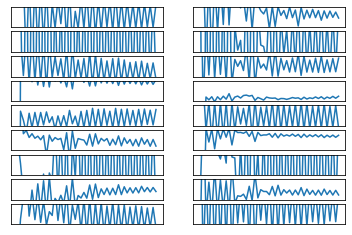


--

GD he sigmoid


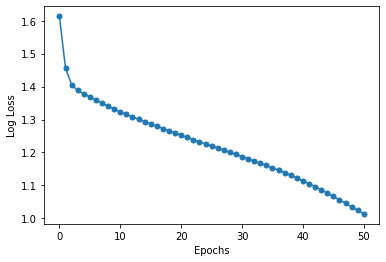

Training accuracy 0.5827
Validation accuracy 0.568


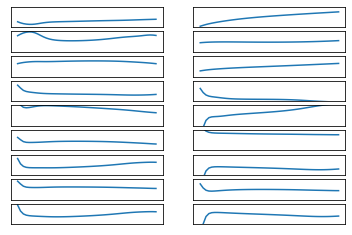


--

GD he tanh


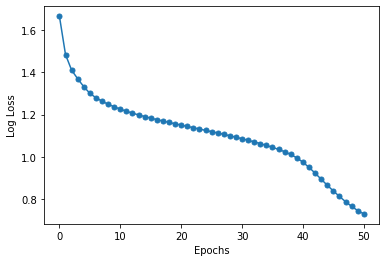

Training accuracy 0.68
Validation accuracy 0.676


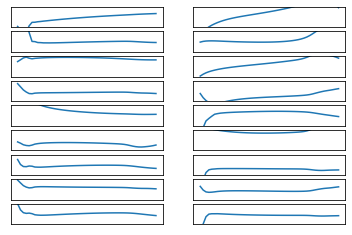


--

GD he relu


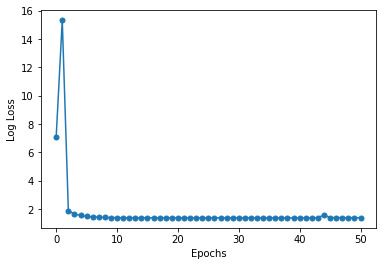

Training accuracy 0.2507
Validation accuracy 0.248


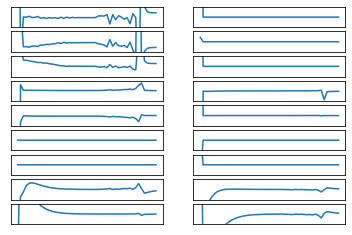


--

GD he leaky_relu


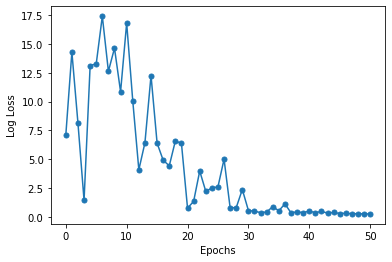

Training accuracy 0.904
Validation accuracy 0.92


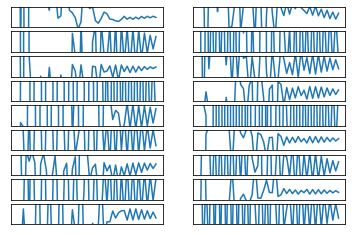


--

MiniBatch zeros sigmoid


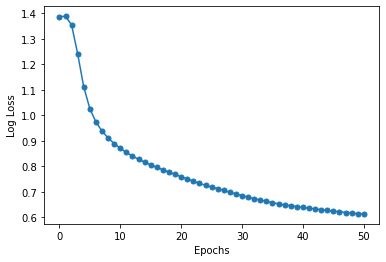

Training accuracy 0.7333
Validation accuracy 0.728


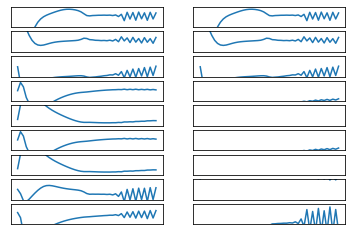


--

MiniBatch zeros tanh


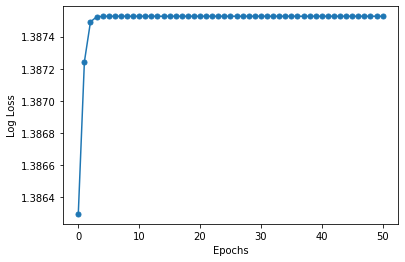

Training accuracy 0.2507
Validation accuracy 0.248


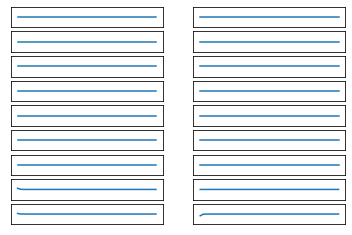


--

MiniBatch zeros relu


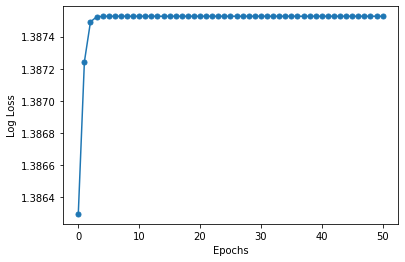

Training accuracy 0.2507
Validation accuracy 0.248


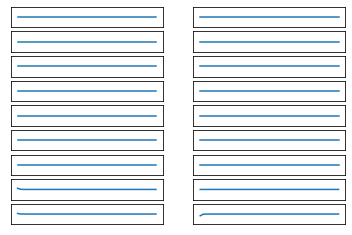


--

MiniBatch zeros leaky_relu


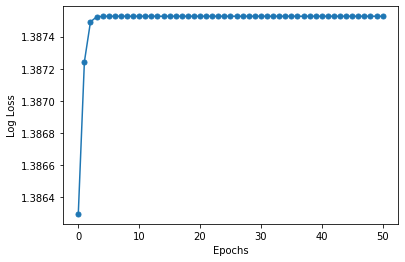

Training accuracy 0.2507
Validation accuracy 0.248


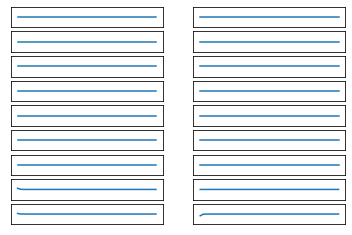


--

MiniBatch random sigmoid


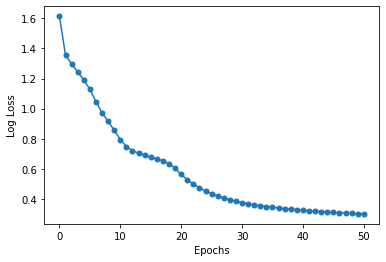

Training accuracy 0.8907
Validation accuracy 0.904


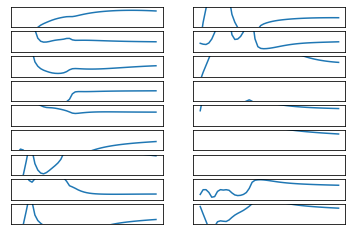


--

MiniBatch random tanh


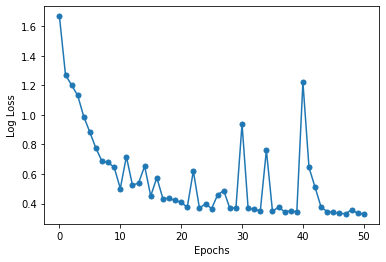

Training accuracy 0.872
Validation accuracy 0.88


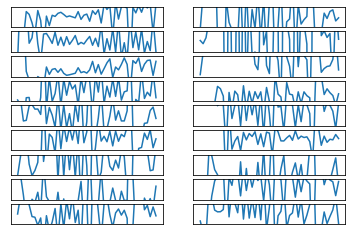


--

MiniBatch random relu


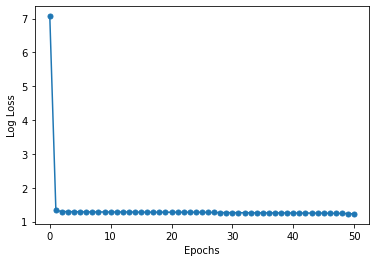

Training accuracy 0.3547
Validation accuracy 0.352


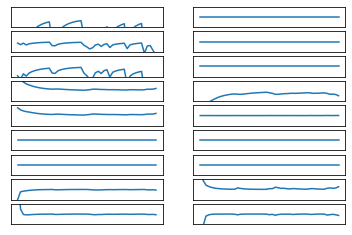


--

MiniBatch random leaky_relu


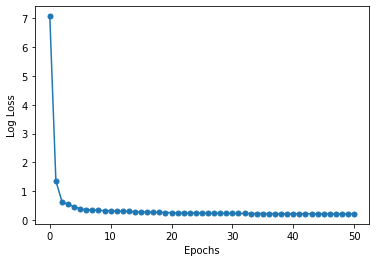

Training accuracy 0.9227
Validation accuracy 0.94


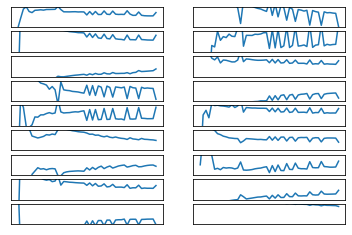


--

MiniBatch Xavier sigmoid


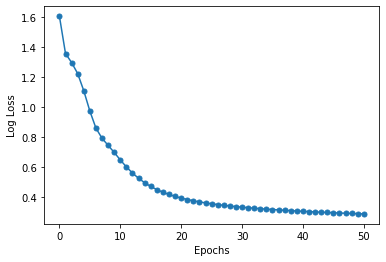

Training accuracy 0.8907
Validation accuracy 0.904


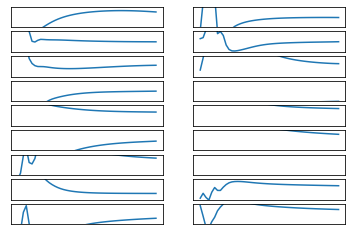


--

MiniBatch Xavier tanh


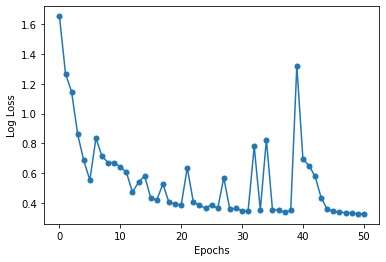

Training accuracy 0.8747
Validation accuracy 0.892


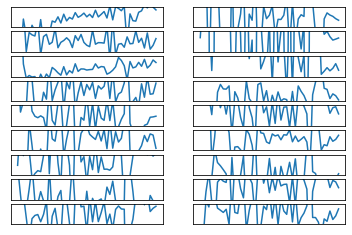


--

MiniBatch Xavier relu


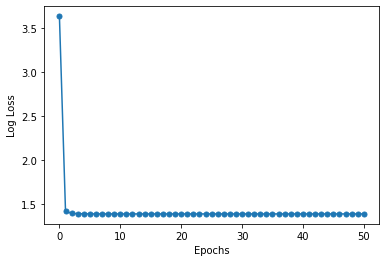

Training accuracy 0.2507
Validation accuracy 0.248


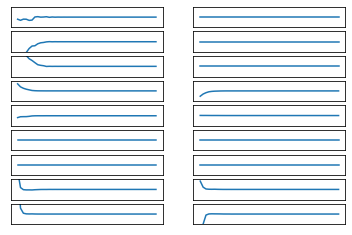


--

MiniBatch Xavier leaky_relu


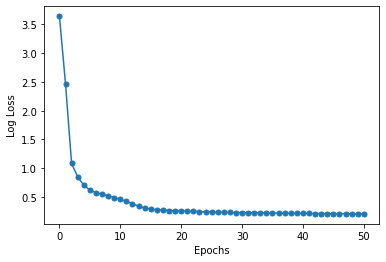

Training accuracy 0.9213
Validation accuracy 0.94


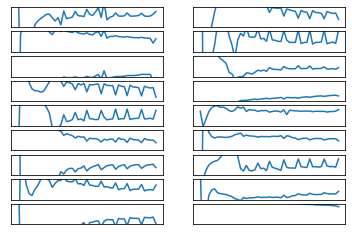


--

MiniBatch he sigmoid


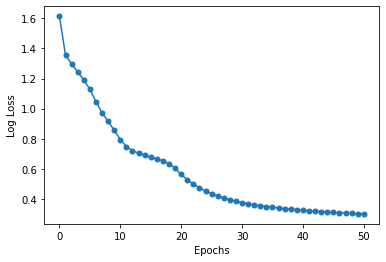

Training accuracy 0.8907
Validation accuracy 0.904


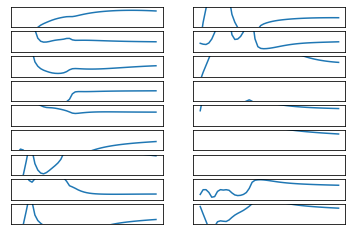


--

MiniBatch he tanh


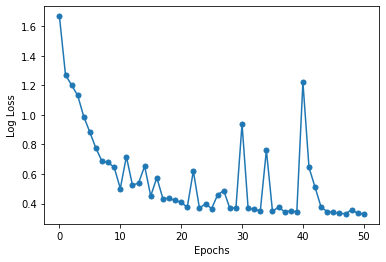

Training accuracy 0.872
Validation accuracy 0.88


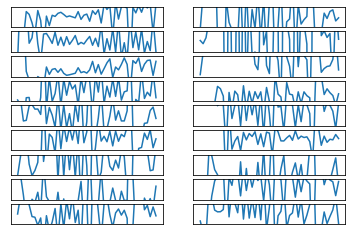


--

MiniBatch he relu


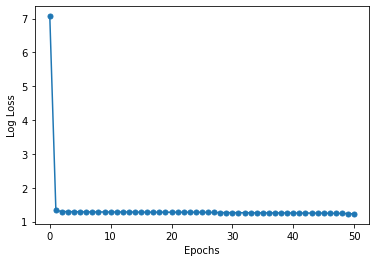

Training accuracy 0.3547
Validation accuracy 0.352


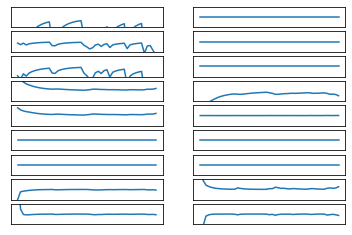


--

MiniBatch he leaky_relu


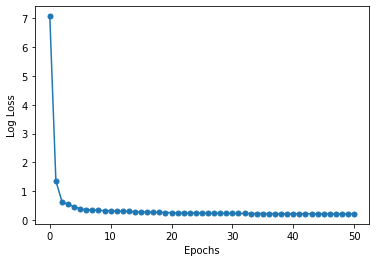

Training accuracy 0.9227
Validation accuracy 0.94


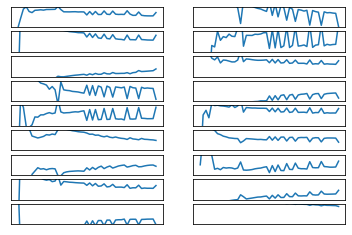


--

Momentum zeros sigmoid
Momentum zeros tanh
Momentum zeros relu
Momentum zeros leaky_relu
Momentum random sigmoid
Momentum random tanh
Momentum random relu
Momentum random leaky_relu
Momentum Xavier sigmoid
Momentum Xavier tanh
Momentum Xavier relu
Momentum Xavier leaky_relu
Momentum he sigmoid
Momentum he tanh
Momentum he relu
Momentum he leaky_relu
NAG zeros sigmoid


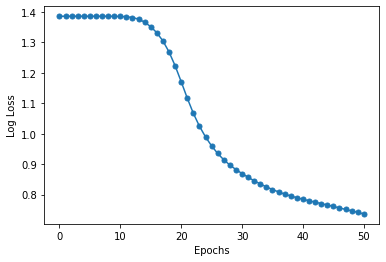

Training accuracy 0.72
Validation accuracy 0.748


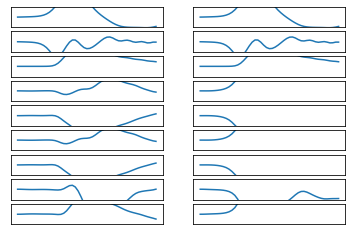


--

NAG zeros tanh


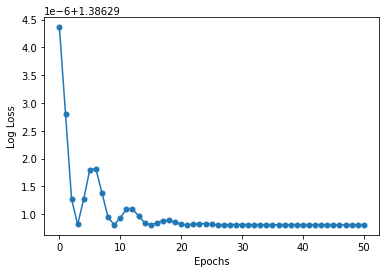

Training accuracy 0.2507
Validation accuracy 0.248


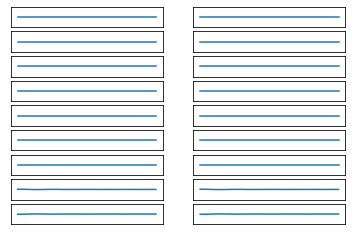


--

NAG zeros relu


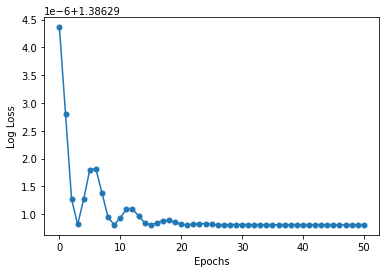

Training accuracy 0.2507
Validation accuracy 0.248


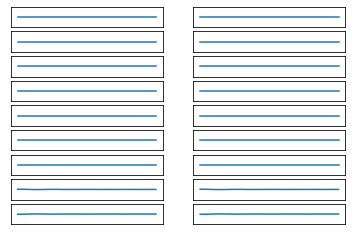


--

NAG zeros leaky_relu


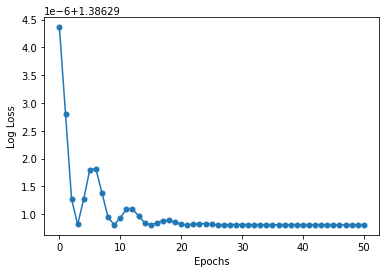

Training accuracy 0.2507
Validation accuracy 0.248


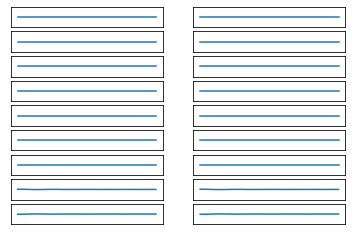


--

NAG random sigmoid


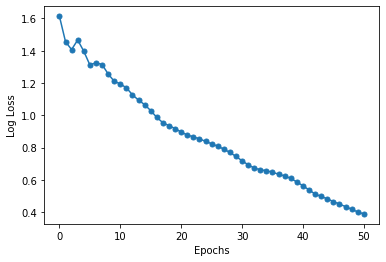

Training accuracy 0.8813
Validation accuracy 0.896


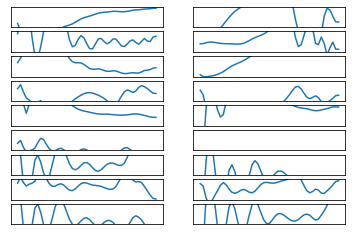


--

NAG random tanh


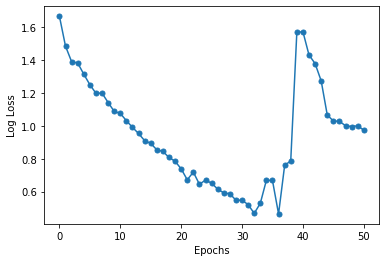

Training accuracy 0.4787
Validation accuracy 0.496


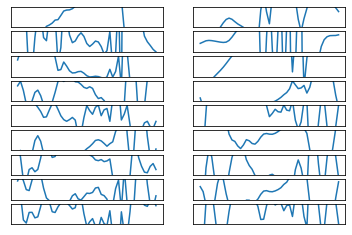


--

NAG random relu


ValueError: ignored

In [ ]:
counter = 0
for gd_variant in gd_variants:
  for init_method in init_methods:
    for act_function in act_functions:
      print(gd_variant, init_method, act_function)
      if (gd_variant=='Momentum'):
        pass
      else:
        model = FFN(n_inputs= 2, n_outputs=4, hidden_layers=[2], init_method= init_method, activation_function= act_function, leaky_slope = 0.1)
        model.fit(X_train, y_OH_train, epochs=50, eta=1, algo=gd_variant, display_loss=True)
        post_process(plot_scale=0.05)
        print('\n--\n')
        counter+=1
print(counter)